In [1]:
from adversarial_lab.core import ALModel
from adversarial_lab.core.noise_generators import AdditiveNoiseGenerator
from adversarial_lab.attacks.whitebox import WhiteBoxMisclassification
from adversarial_lab.core.preprocessing import PreprocessingFromFunction
from adversarial_lab.utils import Plotting
from adversarial_lab.arsenal import CarliniWagnerAttack, ProjectedGradientDescentAttack, DeepFoolAttack

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

In [2]:
model = InceptionV3(weights='imagenet')

def preprocess(sample, *args, **kwargs):
    input = tf.cast(sample, dtype=tf.float32)
    if len(input.shape) == 2:
        input = tf.expand_dims(input, axis=-1)
        input = tf.image.grayscale_to_rgb(input)

    elif len(input.shape) == 3 and input.shape[-1] == 1:
        input = tf.image.grayscale_to_rgb(input)

    input_tensor = tf.convert_to_tensor(input, dtype=tf.float32)
    resized_image = tf.image.resize(input_tensor, (299, 299))
    batch_image = tf.expand_dims(resized_image, axis=0)
    return preprocess_input(batch_image)

pp = PreprocessingFromFunction.create(preprocess)

In [3]:
image = Image.open('data/panda.jpg')
image_array = np.array(image)

np.argmax(model.predict(pp.preprocess(image_array)), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([388], dtype=int64)

In [4]:
attacker = DeepFoolAttack(model=model, preprocessing_fn=pp, learning_rate=0.0001, C=5, kappa=15, epsilon=0.2, verbose=3)

In [5]:
noise = attacker.attack(image_array, target_class=257, target_vector=None, strategy="random", epochs=15)

Attacking:   0%|          | 0/15 [00:00<?, ?it/s]

Attacking:  27%|██▋       | 4/15 [06:51<18:24, 100.44s/it, Loss=7.91, Prediction (score)=388(0.710), Original Class (score)=388(0.710), Target Class (score)=257(0.001)]

Attacking:  33%|███▎      | 5/15 [08:31<16:42, 100.24s/it, Loss=7.52, Prediction (score)=388(0.673), Original Class (score)=388(0.673), Target Class (score)=257(0.001)]

Attacking: 100%|██████████| 15/15 [25:27<00:00, 100.40s/it, Loss=5.3, Prediction (score)=388(0.481), Original Class (score)=388(0.481), Target Class (score)=257(0.006)] 

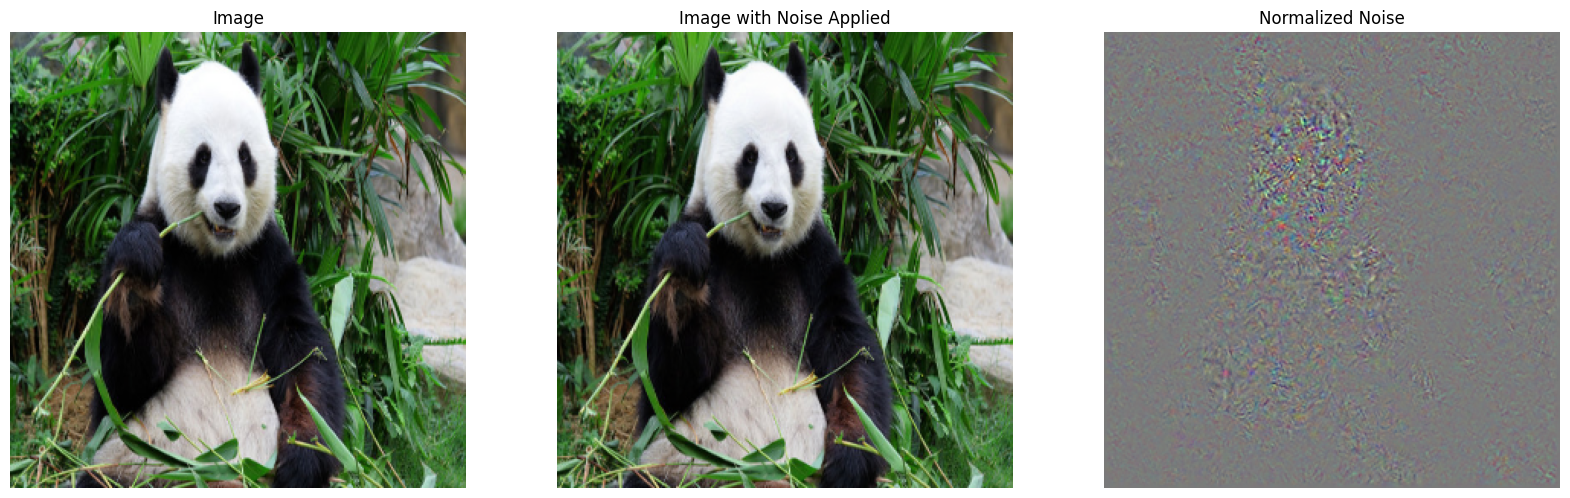

In [9]:
Plotting.plot_images_and_noise(pp.preprocess(image_array).numpy(), noise[0])


In [ ]:
np.max(noise[0])

0.048200242